# ⚛️ H₂ Ground-State VQE — Noisy Ansatz Comparison

This notebook studies **VQE under realistic noise** via the API:

- `run_vqe_ansatz_comparison`
- `run_vqe`

The goal is to understand how noise affects:

- Ansatz stability
- Convergence behaviour
- The final **noisy density matrix**
- Basis-state populations

Noise model (identical for all ansatzes):
- **Depolarizing:** 5%
- **Amplitude damping:** 5%

These values are intentionally exaggerated to make behavioural differences clear.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vqe.core import run_vqe_ansatz_comparison, run_vqe

# Noise settings
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

seed = 0

# Fixed optimizer settings
optimizer_name = "Adam"
steps = 50
stepsize = 0.2


# 🔧 Part 1 — Noisy Ansatz Comparison

`run_vqe_ansatz_comparison(...)`

✔ Runs each ansatz under the same optimizer  
✔ Applies both noise channels  
✔ Handles reproducibility + caching  
✔ Saves a convergence plot  
✔ Returns final energies



🔹 Running ansatz: UCC-S
Step 01/50: E = -0.980595 Ha
Step 02/50: E = -0.980334 Ha
Step 03/50: E = -0.975639 Ha
Step 04/50: E = -0.980424 Ha
Step 05/50: E = -0.978544 Ha
Step 06/50: E = -0.977691 Ha
Step 07/50: E = -0.979812 Ha
Step 08/50: E = -0.980504 Ha
Step 09/50: E = -0.979202 Ha
Step 10/50: E = -0.978866 Ha
Step 11/50: E = -0.979946 Ha
Step 12/50: E = -0.980595 Ha
Step 13/50: E = -0.980041 Ha
Step 14/50: E = -0.979484 Ha
Step 15/50: E = -0.979856 Ha
Step 16/50: E = -0.980496 Ha
Step 17/50: E = -0.980494 Ha
Step 18/50: E = -0.980034 Ha
Step 19/50: E = -0.979941 Ha
Step 20/50: E = -0.980333 Ha
Step 21/50: E = -0.980594 Ha
Step 22/50: E = -0.980403 Ha
Step 23/50: E = -0.980163 Ha
Step 24/50: E = -0.980279 Ha
Step 25/50: E = -0.980544 Ha
Step 26/50: E = -0.980560 Ha
Step 27/50: E = -0.980371 Ha
Step 28/50: E = -0.980329 Ha
Step 29/50: E = -0.980496 Ha
Step 30/50: E = -0.980594 Ha
Step 31/50: E = -0.980497 Ha
Step 32/50: E = -0.980411 Ha
Step 33/50: E = -0.980490 Ha
Step 34/50: E = -0

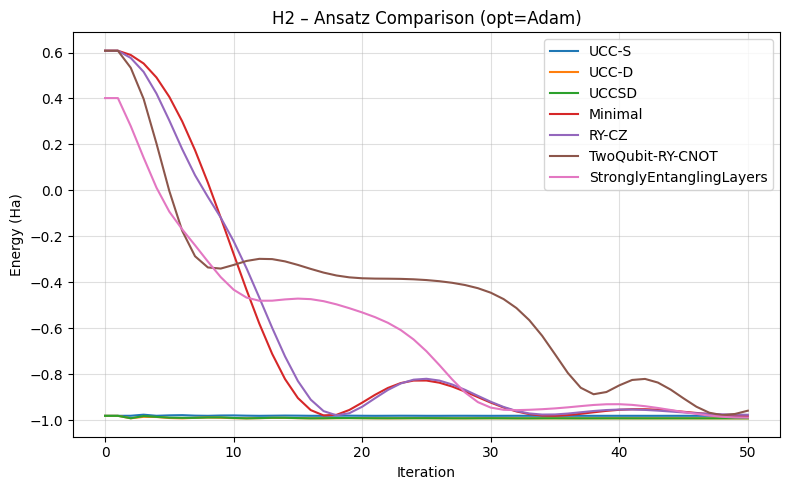

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ansatz_conv_Adam_dep05_amp05_s0.png


In [2]:
# Ansatzes to compare
ansatzes = [
    "UCC-S",
    "UCC-D",
    "UCCSD",
    "Minimal",
    "RY-CZ",
    "TwoQubit-RY-CNOT",
    "StronglyEntanglingLayers",
]

comparison = run_vqe_ansatz_comparison(
    molecule="H2",
    optimizer_name=optimizer_name,
    ansatzes=ansatzes,
    steps=steps,
    stepsize=stepsize,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    mapping="jordan_wigner",
    show=True,
    force=False,
)


# ⭐ Part 2 — Identify the Worst Ansatz

We define the *worst* ansatz as the one with the **highest final energy**.


In [3]:
worst_ansatz = max(
    comparison["final_energies"],
    key=comparison["final_energies"].get
)

print(f"🏆 Worst ansatz under noise: {worst_ansatz}")


🏆 Worst ansatz under noise: TwoQubit-RY-CNOT


# 🔍 Part 3 — Full Noisy VQE Using the Worst Ansatz

We now run a complete noisy VQE with:

- Ansatz: worst performer
- Optimizer: Adam
- Depolarizing: 5%
- Amplitude damping: 5%

`run_vqe(...)` returns energies, metadata, and the full **noisy density matrix**
(because `noisy=True` uses `default.mixed`).


In [4]:
res = run_vqe(
    molecule="H2",
    ansatz_name=worst_ansatz,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    plot=False,
    force=False,
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag = np.diag(rho)

diag



📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_twoqubit_ry_cnot_adam_noisy_dep05_amp05_s0_dc10c4114c4d.json


array([6.82986082e-03+0.j, 3.84038780e-04+0.j, 4.27731950e-04+0.j,
       2.40510986e-05+0.j, 6.97359268e-02+0.j, 3.92120732e-03+0.j,
       4.45905737e-03+0.j, 2.50729992e-04+0.j, 7.28223908e-02+0.j,
       4.09475725e-03+0.j, 4.55683978e-03+0.j, 2.56228236e-04+0.j,
       7.40578295e-01+0.j, 4.16422519e-02+0.j, 4.73539499e-02+0.j,
       2.66268283e-03+0.j])

# 🧮 Part 4 — Approximate Ket Representation

For mixed states, the diagonal entries of ρ correspond to **basis-state populations**.
We display only those above a small threshold.


In [5]:
threshold = 1e-2
num_wires = int(np.log2(len(diag)))

terms = [
    f"({pop:.4f}|{idx:0{num_wires}b}⟩)"
    for idx, pop in enumerate(diag)
    if abs(pop) > threshold
]

ket_estimate = " + ".join(terms)

print("Approximate noisy state (from diagonal of ρ):")
print(f"|ψ⟩ ≈ {ket_estimate}")


Approximate noisy state (from diagonal of ρ):
|ψ⟩ ≈ (0.0697+0.0000j|0100⟩) + (0.0728+0.0000j|1000⟩) + (0.7406+0.0000j|1100⟩) + (0.0416+0.0000j|1101⟩) + (0.0474+0.0000j|1110⟩)


# 📊 Part 5 — Basis-State Population Plot

The bar plot below visualizes **which computational states survive** after noise.


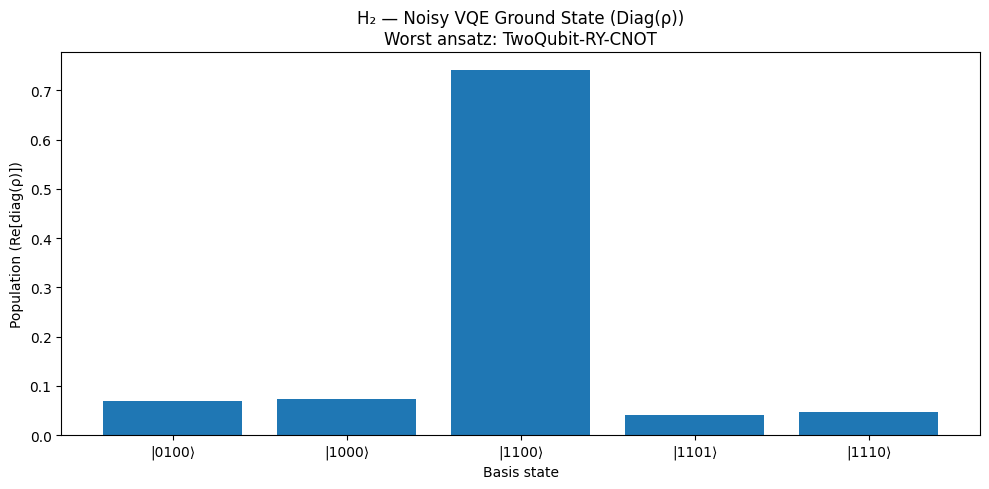

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/Noisy_Ground_State_TwoQubit-RY-CNOT.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/Noisy_Ground_State_TwoQubit-RY-CNOT.png'

In [6]:
indices = np.where(np.abs(diag) > threshold)[0]
vals = diag[indices].real
vals = np.clip(vals, 0.0, None)
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals)

plt.xlabel("Basis state")
plt.ylabel("Population (Re[diag(ρ)])")
plt.title(f"H₂ — Noisy VQE Ground State (Diag(ρ))\nWorst ansatz: {worst_ansatz}")
plt.tight_layout()


from common.plotting import save_plot


out_name = f"Noisy_Ground_State_{worst_ansatz.replace(' ', '_').replace('+','plus')}.png"
save_plot(str(out_name), kind="vqe", molecule="H2", show=True)
